In [1]:
import pandas as pd
import numpy as np
import random

import statistics
import matplotlib.pyplot as plt

from copy import copy


In [2]:
Cities = pd.read_csv('data/predefined_distances.csv')
Cities_Name = Cities['City'].tolist()
Cities_Name = dict(zip(range(1,len(Cities_Name)+1), Cities_Name))
Cities = Cities.iloc[:, 1:]
posiciones = np.where(Cities == 'ND')
Cities = Cities.replace('ND', 80000)

distance = Cities.to_numpy()
distance = distance.astype(int)

tabu=[]
for i in range(len(posiciones[0])):
  tabu.append([posiciones[0][i]+1, posiciones[1][i]+1])


# Population


In [3]:
def new_individuo(genes):
    new=[]
    i=0
    while i<genes:
        aux = random.randint(1,genes)
        if aux not in new:
            new.append(aux)
            i+=1
            
    return new


def generar_poblacion(individuos,genes):
    poblacion = []
    for i in range(individuos):
        poblacion.append(new_individuo(genes))

    return poblacion


# Aptitude

In [4]:
def fitness(generacion):
    d_total = []

    for gen_x in range(len(generacion)):
        suma = 0
        for gen_y in range(-1,len(generacion[0])-1):
            d_1 = generacion[gen_x][gen_y]
            d_2 = generacion[gen_x][gen_y+1]
            suma += distance[d_1-1][d_2-1]
        d_total.append(round(suma,2))
        
    return d_total


def almacenamiento(generacion,fit):
    historial = []
    for individuo in range(len(generacion)):
        historial.append([generacion[individuo],fit[individuo]])

    return historial


def ordenamiento(individuos):
   individuos.sort(key=lambda x:x[1], reverse=False)

   return individuos


# Search Tabu


In [5]:
def genetic_swip(individual,tabu):
  for i in range(0,len(individual)-1):
      tupla = individual[i:i+2]
      if tupla in tabu:
        a,b = individual[i+1],individual[i-(len(individual)-2)]
        individual[i+1],individual[i-(len(individual)-2)]=b,a
  return individual


def search_tabu(individuals,tabu):
  new_individuals = []
  individuals_aux=individuals.copy()
  for ind in range(0,len(individuals_aux)):
    tupla_final = []
    individual = individuals_aux[ind].copy()
    individual = genetic_swip(individual,tabu)
    tupla_final.append([individual[-1],individual[0]])
    if tupla_final[0] in tabu:
        a,b=individual[0],individual[-1]
        individual[0],individual[-1]=b,a
        individual = genetic_swip(individual,tabu)
    new_individuals.append(individual)
  return new_individuals


# Genetic operator selection

Poligamic Selection

In [6]:
def seleccion_poligomico(individuos):
    padre=[]
    for individuo in range(0,len(individuos),2):
        digitos= np.random.randint(len(individuos),size=2)
        padre.append(individuos[digitos[0]])
        padre.append(individuos[digitos[1]])

    return padre


# Partially mapped crossover

In [7]:
def crossover_PMX(padres,tabu):
    hijos=[]
    firstCrossPoint = np.random.randint(0,len(padres[0][0])-2)
    secondCrossPoint = np.random.randint(firstCrossPoint+1,len(padres[0][0])-1)

    for individuo in range(0,len(padres),2):
        padre1=padres[individuo][0]
        padre2=padres[individuo+1][0]

        matriz_correspondencia1=((padres[individuo][0][firstCrossPoint:secondCrossPoint]))
        matriz_correspondencia2=((padres[individuo+1][0][firstCrossPoint:secondCrossPoint]))

        temp_child1= padre1[:firstCrossPoint] + matriz_correspondencia2 + padre1[secondCrossPoint:]
        temp_child2= padre2[:firstCrossPoint] + matriz_correspondencia1 + padre2[secondCrossPoint:]

        relacion=[]
        for i in range(len(matriz_correspondencia1)):
            relacion.append([matriz_correspondencia2[i],matriz_correspondencia1[i]])

        def busqueda1(temp_child,firstCrossPoint,secondCrossPoint,matriz_correspondencia1,matriz_correspondencia2):
            hijo1=np.array([0 for i in range(len(padre1))])

            for i,j in enumerate(temp_child[:firstCrossPoint]):
                c=0
                for x in relacion:
                    if j == x[0]:
                        hijo1[i]=x[1]
                        c=1
                        break
                if c==0:
                    hijo1[i]=j

            j=0
            for i in range(firstCrossPoint,secondCrossPoint):
                hijo1[i]=matriz_correspondencia2[j]
                j+=1

            for i,j in enumerate(temp_child[secondCrossPoint:]):
                c=0
                for x in relacion:
                    if j==x[0]:
                        hijo1[i+secondCrossPoint]=x[1]
                        c=1
                        break
                if c==0:
                    hijo1[i+secondCrossPoint]=j
            hijo_unique1=np.unique(hijo1)

            if len(hijo1) > len(hijo_unique1):
                hijo1=busqueda1(hijo1,firstCrossPoint,secondCrossPoint,matriz_correspondencia1,matriz_correspondencia2)

            return hijo1


        def busqueda2(temp_child,firstCrossPoint,secondCrossPoint,matriz_correspondencia1,matriz_correspondencia2):
            hijo2=np.array([0 for i in range(len(padre1))])
            for i,j in enumerate(temp_child[:firstCrossPoint]):
                c=0
                for x in relacion:
                    if j == x[1]:
                        hijo2[i]=x[0]
                        c=1
                        break
                if c==0:
                    hijo2[i]=j

            j=0
            for i in range(firstCrossPoint,secondCrossPoint):
                hijo2[i]=matriz_correspondencia1[j]
                j+=1

            for i,j in enumerate(temp_child[secondCrossPoint:]):
                c=0
                for x in relacion:
                    if j==x[1]:
                        hijo2[i+secondCrossPoint]=x[0]
                        c=1
                        break
                if c==0:
                    hijo2[i+secondCrossPoint]=j
            hijo_unique2=np.unique(hijo2)

            if len(hijo2) > len(hijo_unique2):
                hijo2=busqueda2(hijo2,firstCrossPoint,secondCrossPoint,matriz_correspondencia1,matriz_correspondencia2)

            return hijo2

        hijo1=busqueda1(temp_child1,firstCrossPoint,secondCrossPoint,matriz_correspondencia1,matriz_correspondencia2)
        hijo2=busqueda2(temp_child2,firstCrossPoint,secondCrossPoint,matriz_correspondencia1,matriz_correspondencia2)
        hijos.append(hijo1.tolist())
        hijos.append(hijo2.tolist())

    hijos=search_tabu(hijos,tabu)
    fit=fitness(hijos)
    hijos=almacenamiento(hijos,fit)
    
    return hijos


# Mutacion (scramble)

In [8]:
def mutacion_scramble(hijos,mutacion):
    hijos_aux=copy(hijos)
    t=int(len(hijos)*mutacion)
    hijos_aux=hijos_aux[:t]
    _hijos=[]

    for individuo in range(len(hijos_aux)):
        hijos.pop(0)
        hijo=hijos_aux[individuo][0]
        firstCross= np.random.randint(0,len(hijo)-2)
        secondCroos= np.random.randint(firstCross+2, firstCross+len(hijo)/2)

        subcadena= hijo[firstCross:secondCroos]

        aux_sub=subcadena.copy()
        while aux_sub == subcadena:
            random.shuffle(subcadena)

        hijo_m=hijo[:firstCross] + hijo[secondCroos:]

        while True:
            pos=np.random.randint(0,len(hijo_m))
            if pos != firstCross:
                break

        temporal=hijo_m[pos:]
        hijo_m=hijo_m[:pos] + subcadena + temporal
        _hijos.append(hijo_m)

    fit=fitness(_hijos)
    _hijos=almacenamiento(_hijos,fit)
    for i in range(len(_hijos)):
        hijos.insert(0,_hijos[i])

    return hijos


# Criterio elitista

Competencia genetica

In [9]:
def competencia_genetica(padres,hijos):
    competencia = []
    competencia = padres+hijos
    competencia = ordenamiento(competencia)
    competencia = competencia[0:len(competencia)//2]
    return competencia


def promedio(individuos):
    media=[]
    for i in range(len(individuos)):
        media.append(individuos[i][1])
    return media


In [10]:
def nueva_generacion(primera_generacion,mutacion,tabu):
    padres = seleccion_poligomico(primera_generacion)
    hijos = crossover_PMX(padres,tabu)
    hijos = mutacion_scramble(hijos,mutacion)
    Nueva_generacion = competencia_genetica(padres,hijos)

    return Nueva_generacion

def Genetic_Algorithm(tabu,cromosomas,generaciones,mutacion,title):
    genes = 18
    primera_poblacion = generar_poblacion(cromosomas,genes)
    primera_poblacion = search_tabu(primera_poblacion,tabu)
    fit=fitness(primera_poblacion)
    primera_generacion = almacenamiento(primera_poblacion,fit)

    #Variables
    Mejor_ruta = []
    x = []
    y = []
    delta = 0
    best_fitness = 80000
    y_media = []
    generacion = 0
    while generacion<generaciones:
        primera_generacion = ordenamiento(primera_generacion)
        Mejor_ruta.append(primera_generacion[0])
        x.append(generacion+1)
        y.append(primera_generacion[0][1])
        prom = promedio(primera_generacion)
        y_media.append(statistics.mean(prom))
        Nueva_generacion = nueva_generacion(primera_generacion,mutacion,tabu)


        if y_media[generacion] == Nueva_generacion[0][1]:
          break

        primera_generacion=Nueva_generacion.copy()
        generacion+=1

    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(y_media, "o-",label="Average aptitude")
    plt.plot(y, "o-", label="Best aptitude")
    plt.xlabel("Generation")
    plt.ylabel("Aptitude")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.savefig(f"./figures/{'_'.join(title.replace('+', '').lower().split())}.png", bbox_inches='tight')
    plt.show()

    return Mejor_ruta


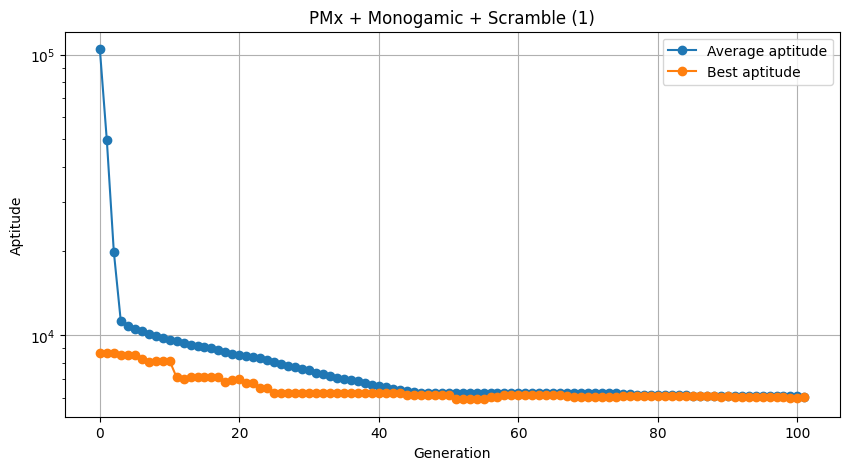

La mejor ruta es:  [[7, 8, 13, 6, 11, 10, 9, 2, 1, 4, 15, 14, 18, 16, 17, 12, 3, 5], 6057]


['Bordeaux',
 'Toulouse',
 'Geneva',
 'Lyon',
 'Luxemburgo',
 'Brussels',
 'Amsterdam',
 'Hamburg',
 'Berlin',
 'Munich',
 'Linz',
 'Vienna',
 'Naples',
 'Rome',
 'Florencia',
 'Zurich',
 'Stuttgart',
 'Paris']

In [11]:
title = "PMx + Monogamic + Scramble (1)"
mejor = Genetic_Algorithm(tabu, cromosomas=2000, generaciones=500, mutacion=0.2, title=title)
ruta = []
for x,y in enumerate(mejor[-1][0]):
  ruta.append(Cities_Name[y])
print('La mejor ruta es: ', mejor[-1])
ruta


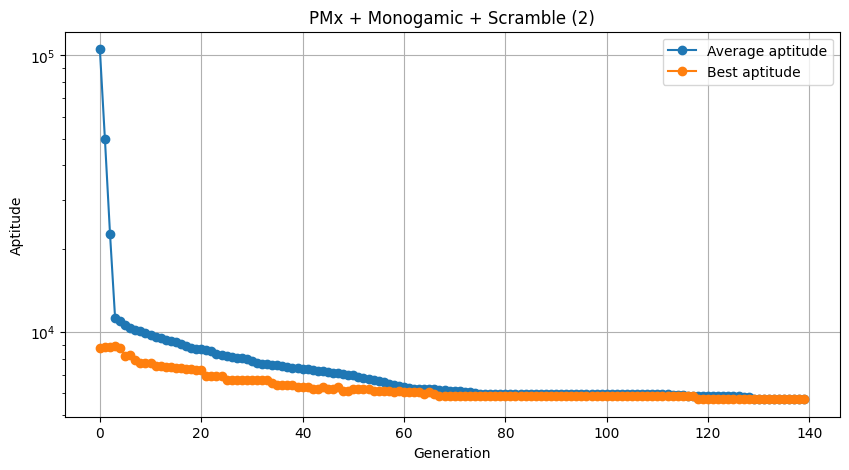

La mejor ruta es:  [[10, 9, 2, 1, 14, 15, 4, 3, 12, 17, 18, 16, 13, 6, 8, 7, 5, 11], 5707]


['Brussels',
 'Amsterdam',
 'Hamburg',
 'Berlin',
 'Vienna',
 'Linz',
 'Munich',
 'Stuttgart',
 'Zurich',
 'Florencia',
 'Naples',
 'Rome',
 'Geneva',
 'Lyon',
 'Toulouse',
 'Bordeaux',
 'Paris',
 'Luxemburgo']

In [12]:
title = "PMx + Monogamic + Scramble (2)"
mejor = Genetic_Algorithm(tabu, cromosomas=2000, generaciones=500, mutacion=0.2, title=title)
ruta = []
for x,y in enumerate(mejor[-1][0]):
  ruta.append(Cities_Name[y])
print('La mejor ruta es: ', mejor[-1])
ruta


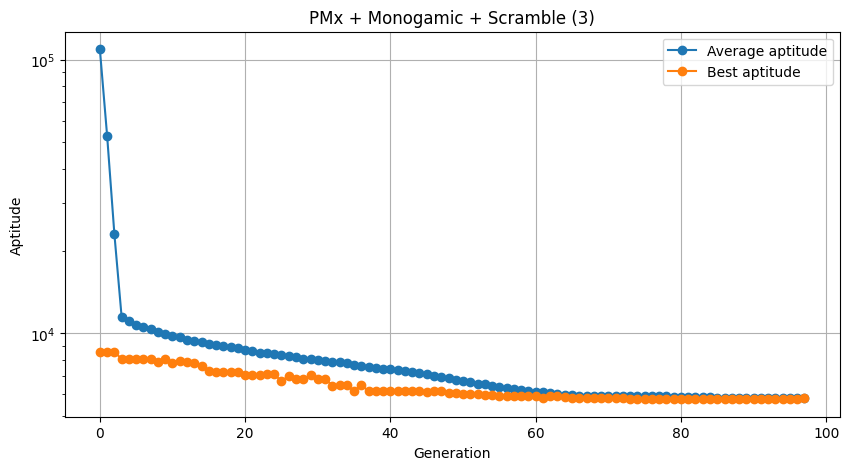

La mejor ruta es:  [[9, 2, 1, 4, 15, 14, 18, 16, 17, 8, 7, 6, 13, 12, 3, 11, 5, 10], 5822]


['Amsterdam',
 'Hamburg',
 'Berlin',
 'Munich',
 'Linz',
 'Vienna',
 'Naples',
 'Rome',
 'Florencia',
 'Toulouse',
 'Bordeaux',
 'Lyon',
 'Geneva',
 'Zurich',
 'Stuttgart',
 'Luxemburgo',
 'Paris',
 'Brussels']

In [13]:
title = "PMx + Monogamic + Scramble (3)"
mejor = Genetic_Algorithm(tabu, cromosomas=2000, generaciones=500, mutacion=0.2, title=title)
ruta = []
for x,y in enumerate(mejor[-1][0]):
  ruta.append(Cities_Name[y])
print('La mejor ruta es: ', mejor[-1])
ruta


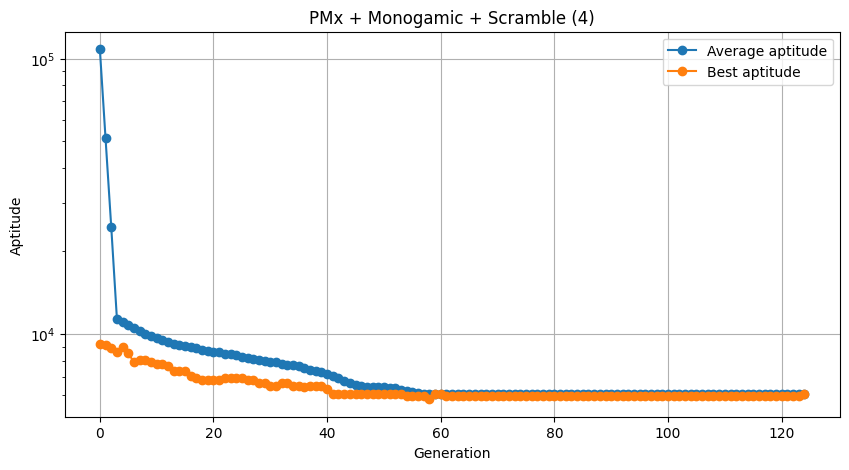

La mejor ruta es:  [[4, 3, 12, 17, 18, 16, 6, 13, 8, 7, 5, 11, 9, 10, 2, 1, 15, 14], 6043]


['Munich',
 'Stuttgart',
 'Zurich',
 'Florencia',
 'Naples',
 'Rome',
 'Lyon',
 'Geneva',
 'Toulouse',
 'Bordeaux',
 'Paris',
 'Luxemburgo',
 'Amsterdam',
 'Brussels',
 'Hamburg',
 'Berlin',
 'Linz',
 'Vienna']

In [14]:
title = "PMx + Monogamic + Scramble (4)"
mejor = Genetic_Algorithm(tabu, cromosomas=2000, generaciones=500, mutacion=0.2, title=title)
ruta = []
for x,y in enumerate(mejor[-1][0]):
  ruta.append(Cities_Name[y])
print('La mejor ruta es: ', mejor[-1])
ruta


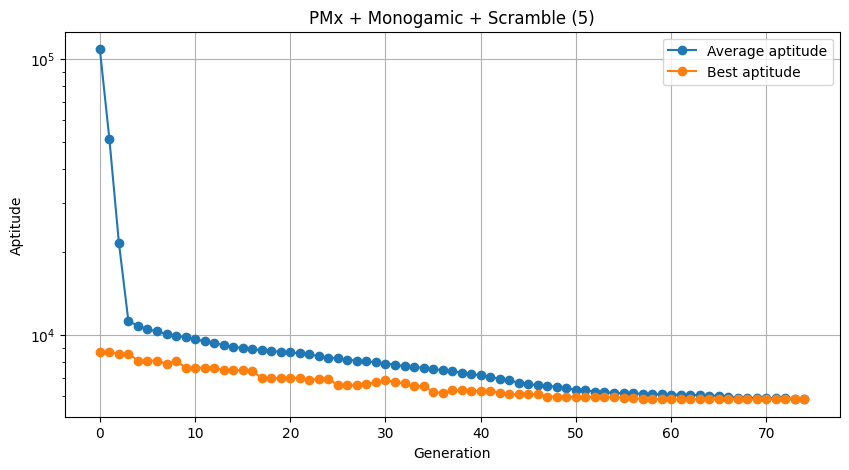

La mejor ruta es:  [[2, 1, 12, 3, 4, 15, 14, 18, 16, 17, 13, 6, 8, 7, 5, 11, 10, 9], 5846]


['Hamburg',
 'Berlin',
 'Zurich',
 'Stuttgart',
 'Munich',
 'Linz',
 'Vienna',
 'Naples',
 'Rome',
 'Florencia',
 'Geneva',
 'Lyon',
 'Toulouse',
 'Bordeaux',
 'Paris',
 'Luxemburgo',
 'Brussels',
 'Amsterdam']

In [15]:
title = "PMx + Monogamic + Scramble (5)"
mejor = Genetic_Algorithm(tabu, cromosomas=2000, generaciones=500, mutacion=0.2, title=title)
ruta = []
for x,y in enumerate(mejor[-1][0]):
  ruta.append(Cities_Name[y])
print('La mejor ruta es: ', mejor[-1])
ruta
